In [ ]:
import torch
import numpy as np
import pandas as pd
import tqdm
import time

from matplotlib import pyplot as plt

In [ ]:
df = pd.read_csv('international-airline-passengers.csv')


In [ ]:
df['month'] = pd.to_datetime(df['Month']).dt.month

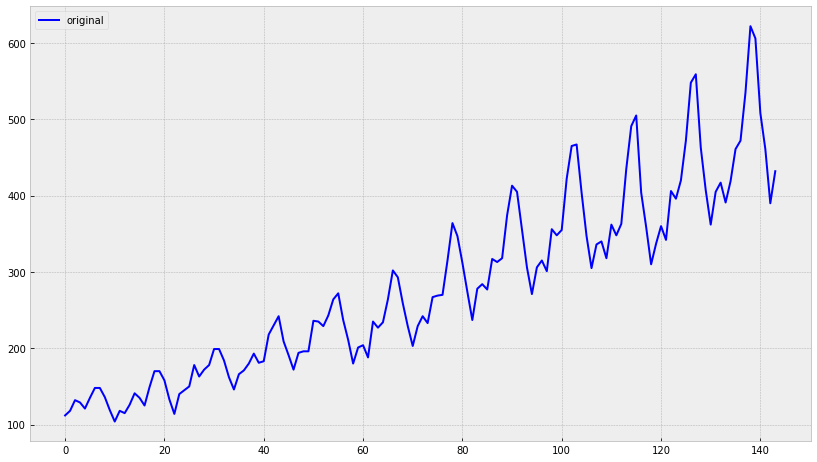

In [ ]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(df["Count"], color='blue',label='original')
    plt.legend()

Делим наш датасет на train и test

In [ ]:
df_train = df.iloc[:120]
df_test = df.iloc[120:]

Формируем датасеты для обучения и тестирования


In [ ]:
df.iloc[0:0+10][['month','Count']].to_numpy().shape

(10, 2)

In [ ]:
def get_train_test(df):
  X = []
  y = []
  for i in range(df.shape[0]-11):
    X.append(df.iloc[i:i+10][['month','Count']].to_numpy())
    y.append(df.iloc[i+11]['Count'])
  return np.array(X), np.array(y).reshape(-1,1)


In [ ]:
X_train, y_train = get_train_test(df_train)

In [ ]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()


In [ ]:
X_test, y_test = get_train_test(df_test)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
X_all, y_all = get_train_test(df)
X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

создаем датасет

In [ ]:
BATCH_SIZE=10
dataset = torch.utils.data.TensorDataset(X_train, y_train)
data = torch.utils.data.DataLoader(dataset, BATCH_SIZE, shuffle=True)


создаем модель

In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, rnnClass, input_size, num_layers, num_hiddens):
        super().__init__()
        self.hidden = rnnClass(input_size, num_hiddens, batch_first=True, num_layers=num_layers)
        self.output = torch.nn.Linear(num_hiddens, 1)
        
    def forward(self, X):
        _, state = self.hidden(X)
        predictions = self.output(state[0])
        return predictions

In [ ]:
model = NeuralNetwork(torch.nn.RNN, 2, 1, 128)

In [ ]:
model = model.cuda()

обучаем модель

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
for ep in tqdm.tqdm_notebook(range(5001)):
    start = time.time()
    train_loss = 0.
    train_passed = 0

    model.train()
    for X_b, y_b in data:
        X_b, y_b = X_b.cuda(), y_b.cuda()
        optimizer.zero_grad()
        answers = model(X_b)
        loss = criterion(answers, y_b)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        train_passed += 1

    if ep % 1000 == 0:
        print("Epoch {}. Time: {:.3f}, Train loss: {:.3f}".format(ep, time.time() - start, train_loss / train_passed))


NameError: ignored

In [ ]:
model.eval()
test_pred = model(X_test.cuda())

print(criterion(test_pred.detach().cpu(), y_test))

tensor(9229.7598)


In [ ]:
all_pred = model(X_all.cuda())
print(criterion(all_pred.detach().cpu(), y_all))

tensor(1022.7453)


In [ ]:
X_prog = X_train[-1].clone().detach()
y_prog = y_train.clone().detach()

In [ ]:
for i in range(60):
    prog_pred = model(X_prog[-10:].unsqueeze(0).cuda()).detach().cpu().item()
    prog_m = (X_prog[-1,1].item()+1)%12
    X_prog = torch.cat([X_prog, torch.Tensor([[prog_m, prog_pred]])])
    y_prog = torch.cat([y_prog, torch.Tensor([[prog_pred]])])

    

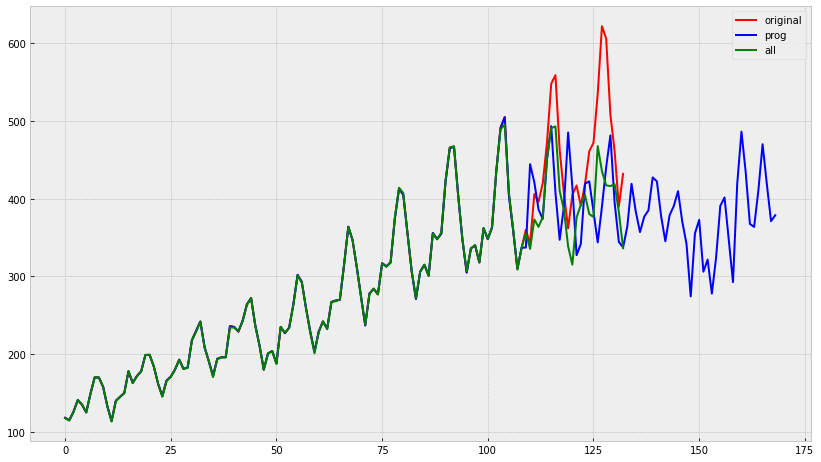

In [ ]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(df["Count"][11:].tolist(), color='red',label='original')
    plt.plot(y_prog, color='blue',label='prog')
    plt.plot(all_pred.detach().cpu(), color='green',label='all')
    plt.legend()